# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Neural-net-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import glob
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from math import ceil
from pathlib import Path
from GEORGE_Library import *
%matplotlib inline

print("Done")

Using TensorFlow backend
Done


## Define global variables

In [2]:
label_id_offset = 1
score_threshold = 0.7
category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'pollen'}, 3: {'id': 3, 'name': 'varroa'}, 4: {'id': 4, 'name': 'wasps'}}
val_augmented_fp = "Dataset/Custom_Dataset/Validation"
model_directory = 'C:/Users/khard/OneDrive/Documents/GitHub/GEORGE/'
model_name = 'extract_superimp_model'
model_dest = os.path.join(os.sep, model_directory, model_name)

print("Done")

Done


# Load test images and run inference with new model!

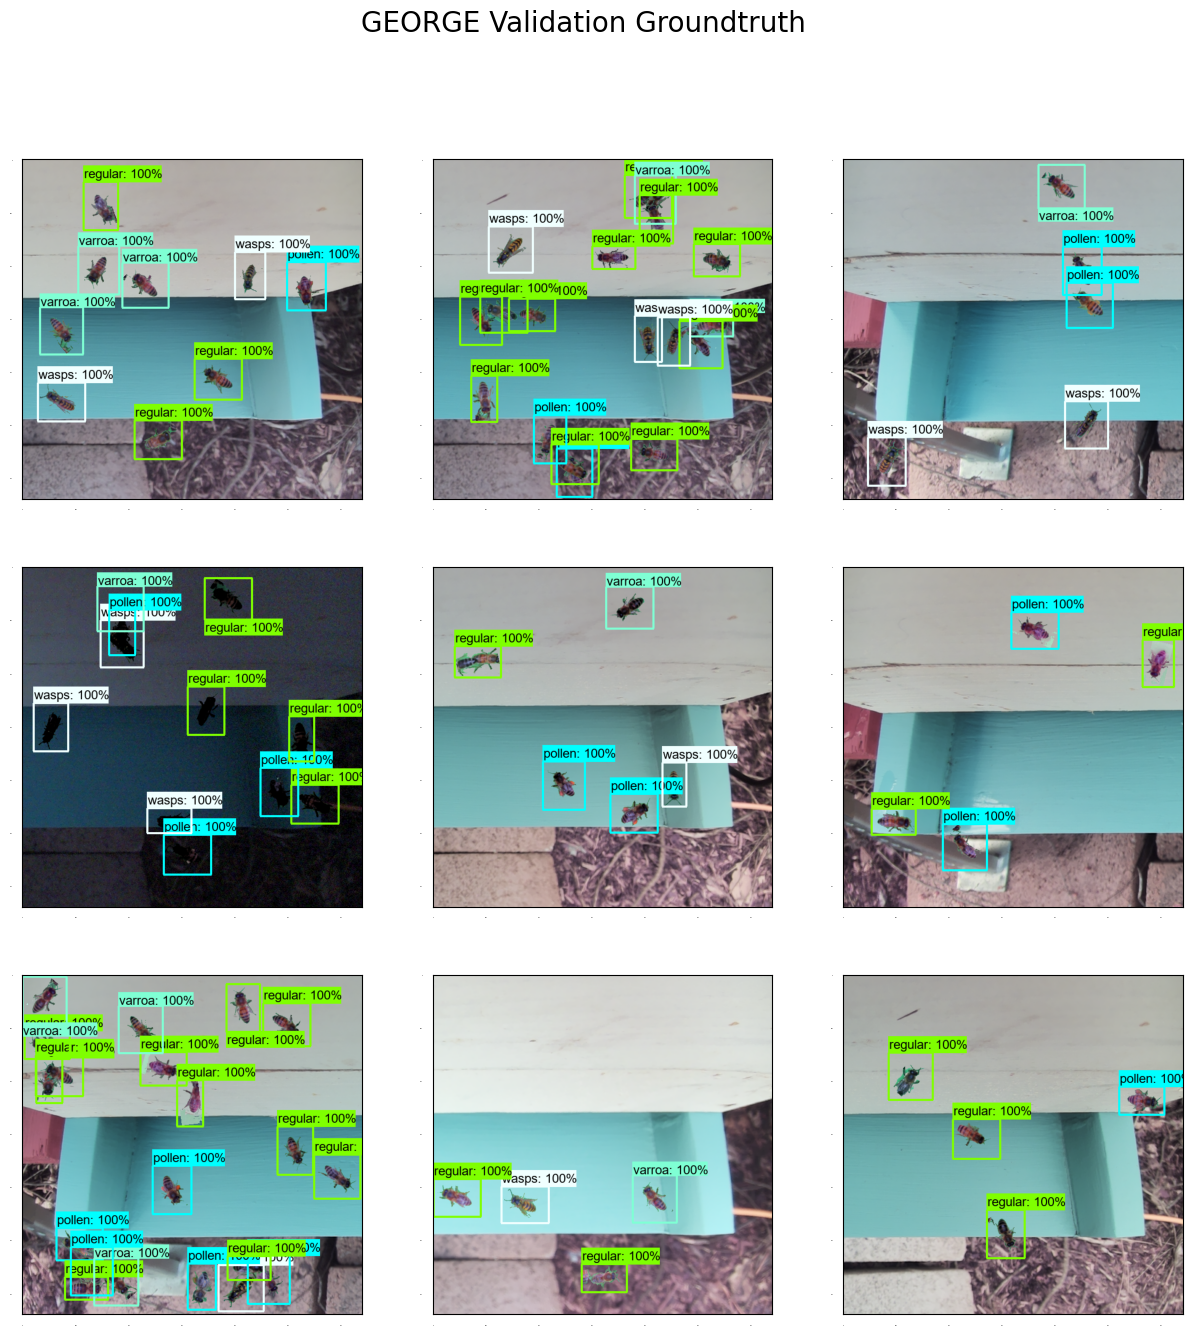

In [3]:
file_list = glob.glob(val_augmented_fp + '/*')

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [15, 15]

num_images = 9
save_plot = True

i = 0

coco_annotations_file = val_augmented_fp + "/custom_bee_dataset.json"
coco_images_dir=os.getcwd() + "\\" + val_augmented_fp
coco= COCOParser(coco_annotations_file, coco_images_dir)

while i < num_images:
    img_id = int(Path(file_list[i]).stem)
    image = np.array(Image.open(file_list[i]).convert('RGB')).astype('uint8')
    ax = plt.subplot(int(ceil(num_images)/3), 3, i + 1)

    ann_ids = coco.get_annIds(img_id)
    img_w, img_h = coco.get_wh(img_id)
    annotations = coco.load_anns(ann_ids)

    bboxes = []
    class_ids = []
    
    for ann in annotations:
        _bbox = ann['bbox']
        x, y, w, h = [int(b) for b in _bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        bboxes.append(coco_to_rel_yxyx(x, y, w, h, 640, 640))
        class_ids.append(class_id)

    plot_detections(
    image,
    np.asarray(bboxes),
    np.asarray(class_ids),
    np.ones(len(bboxes)),
    category_index)#, figsize=(30, 15))

    i = i + 1
                  
plt.suptitle('GEORGE Validation Groundtruth', fontsize=20)
plt.show()

Images:   2%|█▏                                                      | 455/21250 [02:59<2:16:57,  2.53image/s, image=9]


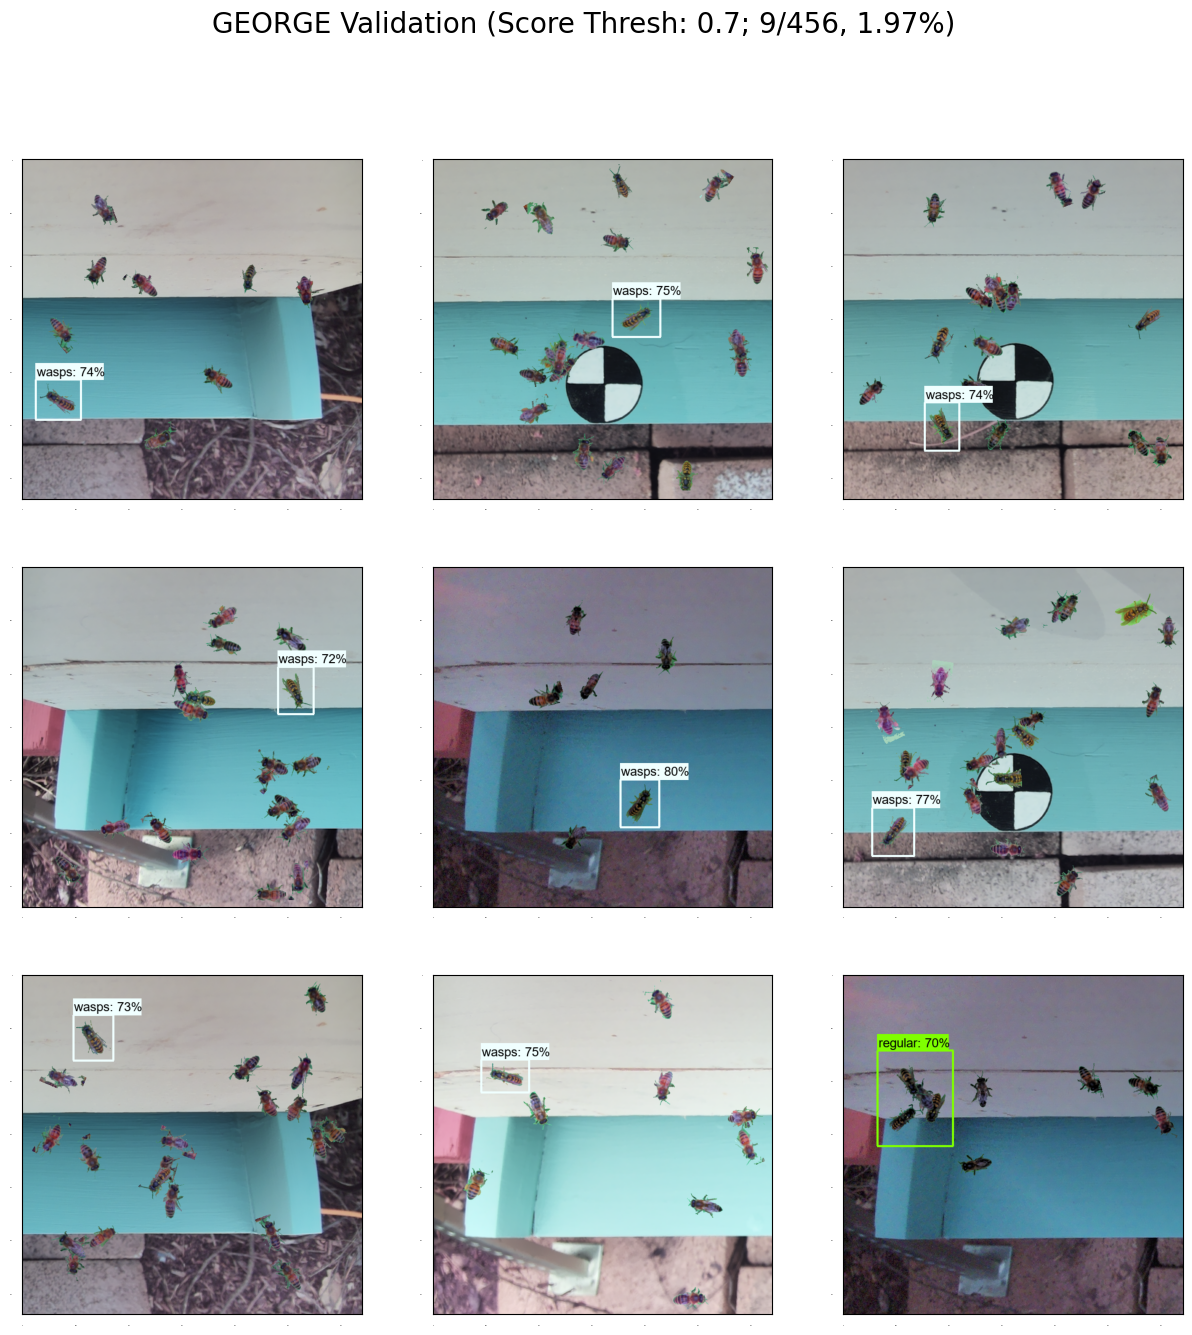

In [4]:
file_list = glob.glob(val_augmented_fp + '/*.png')
new_model = tf.saved_model.load(model_dest)

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [15, 15]

num_images = 9
save_plot = True

i = 0
j = 0

coco_annotations_file = val_augmented_fp + "/custom_bee_dataset.json"
coco_images_dir=os.getcwd() + "\\" + val_augmented_fp
coco= COCOParser(coco_annotations_file, coco_images_dir)

with tqdm(total = len(file_list), unit="image") as pbar:
    pbar.set_description(desc="Images")
    while i < num_images:
        img_id = int(Path(file_list[j]).stem)
        image = np.array(Image.open(file_list[j]).convert('RGB')).astype('uint8')
        ax = plt.subplot(int(ceil(num_images)/3), 3, i + 1)
    
        bboxes = []
        class_ids = []
        scores = []

        input_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        input_tensor = tf.expand_dims(input_tensor, 0)
        detections = new_model.signatures['detect'](input_tensor)
    
        for k in range(len(detections['detection_boxes'][0])):
            if detections['detection_scores'][0][k].numpy() >= score_threshold:
                y1, x1, y2, x2  = np.array(detections['detection_boxes'][0][k])
                bboxes.append([y1, x1, y2, x2])
                class_id = detections['detection_classes'][0][k].numpy().astype(np.uint32) + label_id_offset
                class_name = category_index[class_id]['name']
                score = detections['detection_scores'][0][k].numpy()
                class_ids.append(class_id)
                scores.append(score)
    
        if not scores == []:
            plot_detections(
            image,
            np.asarray(bboxes),
            np.asarray(class_ids),
            scores,
            category_index)#, figsize=(30, 15))

            i = i + 1
            j = j + 1
        else:
            j = j + 1
        pbar.set_postfix(image=i)
        pbar.update(1)
                  
plt.suptitle('GEORGE Validation (Score Thresh: %s; %s/%s, %s%%)' % (score_threshold, num_images, j + 1, round((num_images/(j+1))*100,2)), fontsize=20)
if save_plot:
    plt.savefig('GEORGE_Validation_Plot.png')
plt.show()